In [5]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [2]:
pip install trimesh

     |████████████████████████████████| 637 kB 8.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

     |████████████████████████████████| 199.0 MB 28 kB/s s eta 0:00:01     |█████████████████████████▏      | 156.3 MB 72.7 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 33.8 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 6.5 MB/s  eta 0:00:01
     |████████████████████████████████| 5.6 MB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 131 kB 56.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.7 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 16.7 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 23.8 MB/s eta 0:00:01
     |████████████████████████████████| 152 kB 44.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 13.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 6.3 MB/s eta 0:00:01
     |██████████████████████████████

In [6]:
DATA_DIR=tf.keras.utils.get_file("modelnet.zip",
                                "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
                                extract=True)
DATA_DIR=os.path.join(os.path.dirname(DATA_DIR),"ModelNet10")

473415680/473402300 [==============================] - 6s 0us/step


In [7]:
mesh=trimesh.load(os.path.join(DATA_DIR,"chair/train/chair_0001.off"))
mesh.show()

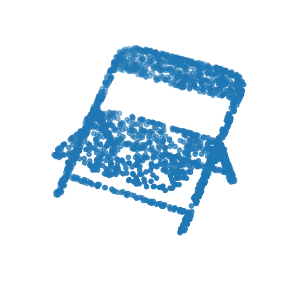

In [8]:
points=mesh.sample(2048)

fig=plt.figure(figsize=(5,5))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(points[:,0],points[:,1],points[:,2])
ax.set_axis_off()
plt.show()

In [12]:
def parse_dataset(num_points=2048):
    train_points=[]
    train_labels=[]
    test_points=[]
    test_labels=[]
    class_map={}
    folders = glob.glob(os.path.join(DATA_DIR,"[!README]*"))
    
    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all the files
        train_files=glob.glob(os.path.join(folder,"train/*"))
        test_files=glob.glob(os.path.join(folder,"test/*"))
        
        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
            
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map)


In [13]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: bed
processing class: monitor
processing class: desk
processing class: chair
processing class: dresser
processing class: toilet
processing class: sofa
processing class: table
processing class: night_stand
processing class: bathtub


In [14]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape,-0.005, 0.005, dtype=tf.float64)
    # shuffle points - so the model isn't biased towards a particular ordering
    points = tf.random.shuffle(points)
    return points, label

train_dataset = tf.data.Dataset.from_tensor_slices((train_points,train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points,test_labels))

train_dataset=train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [31]:
def conv_bn(x,filters):
    x = layers.Conv1D(filters,kernel_size=1,padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

def dense_bn(x,filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [32]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self,num_features,reg=0.001):
        self.num_features = num_features
        self.reg=reg
        self.eye=tf.eye(num_features)
    
    def __call__(self,x):
        x = tf.reshape(x, (-1,self.num_features,self.num_features))
        xxt = tf.tensordot(x, x, axes=(2,2))
        xxt = tf.reshape(xxt,(-1, self.num_features,self.num_features))
        return tf.reduce_sum(self.reg * tf.square(xxt - self.eye))

In [33]:
def tnet(inputs, num_features):
    
    # Initialize bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs,32)
    x = conv_bn(x,64)
    x = conv_bn(x,512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(num_features * num_features,kernel_initializer="zeros",
                    bias_initializer=bias,activity_regularizer=reg)(x)
    feat_T = layers.Reshape((num_features,num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2,1))([inputs,feat_T])

In [34]:
inputs = keras.Input(shape=(NUM_POINTS,3))

x = tnet(inputs,3)
x = conv_bn(x,32)
x = conv_bn(x,32)
x = tnet(x,32)
x = conv_bn(x,32)
x = conv_bn(x,64)
x = conv_bn(x,512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs,outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 2048, 32)     128         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 2048, 32)     128         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 2048, 32)     0           batch_normalization_6[0][0]      
___________________________________________________________________________________________

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.Adam(learning_rate=0.001),
             metrics=["sparse_categorical_accuracy"])

model.fit(train_dataset,epochs=20,validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 599s 5s/step - loss: 3.4921 - sparse_categorical_accuracy: 0.2944 - val_loss: 3785440561725440.0000 - val_sparse_categorical_accuracy: 0.3568
Epoch 2/20
125/125 [==============================] - 543s 4s/step - loss: 2.8908 - sparse_categorical_accuracy: 0.4485 - val_loss: 14908651994968227840.0000 - val_sparse_categorical_accuracy: 0.4185
Epoch 3/20
125/125 [==============================] - 547s 4s/step - loss: 2.5731 - sparse_categorical_accuracy: 0.5565 - val_loss: 123717648.0000 - val_sparse_categorical_accuracy: 0.4570
Epoch 4/20
125/125 [==============================] - 555s 4s/step - loss: 2.4716 - sparse_categorical_accuracy: 0.5953 - val_loss: 701246113646116864.0000 - val_sparse_categorical_accuracy: 0.6046
Epoch 5/20
125/125 [==============================] - 570s 5s/step - loss: 2.2998 - sparse_categorical_accuracy: 0.6319 - val_loss: 2643.7278 - val_sparse_categorical_accuracy: 0.3359
Epoch 6/20
125/125 [=============

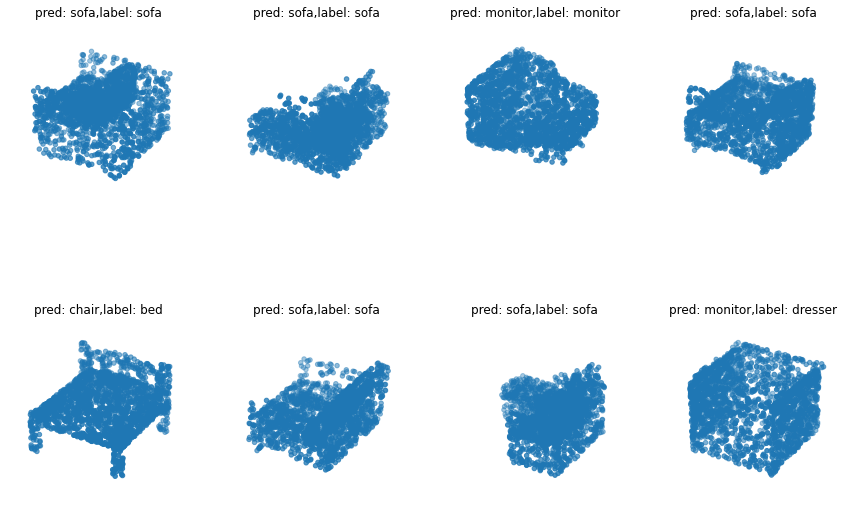

In [39]:
data = test_dataset.take(1)

points,labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds,-1)

points = points.numpy()

# plot points with predicted lass and label
fig = plt.figure(figsize=(15,10))
for i in range(8):
    ax = fig.add_subplot(2,4,i+1,projection="3d")
    ax.scatter(points[i,:,0],points[i,:,1],points[i,:,2])
    ax.set_title("pred: {:},label: {:}".format(
    CLASS_MAP[preds[i].numpy()],CLASS_MAP[labels.numpy()[i]]))
    
    ax.set_axis_off()
plt.show()